In [173]:
import numpy as np
import json
from collections import defaultdict
from scipy import spatial
import matplotlib.pyplot as plt
from collections import Counter
from validate_semantics import load_wordnet_axes, get_glove_vecs, get_bert_vecs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity

In [174]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

### Axes in vector space

In [4]:
axes, axes_vocab = load_wordnet_axes()
glove_vecs = get_glove_vecs(set(), axes_vocab, exp_name='default')

In [213]:
def show_top_axes(path, scores, show_bias_sep=False):
    with open(path, 'r') as infile:
        biases = json.load(infile) # {c : { pole : (bias, effect) } }
        
    if show_bias_sep: 
        for c in biases: 
            print("---- BIAS SEPARATION ----", c)
            print('sep\tbias other\tbias this')
            vals = []
            dims = []
            for pole in biases[c]: 
                if scores[pole + '_left'] > 0 and scores[pole + '_right'] > 0: 
                    dims.append((pole, round(biases[c][pole][0], 3), round(biases[c][pole][2], 3), round(biases[c][pole][3], 3)))
                    vals.append(biases[c][pole][0])
            sorted_dims = [x for _,x in sorted(zip(vals,dims))]
            for i in range(1, 6):
                pole, sep, bias1, bias2 = sorted_dims[-i]
                left, right = axes[pole]
                if bias2 > 0: 
                    this_side = left
                else: 
                    this_side = right
                if bias1 * bias2 >= 0: 
                    # same side 
                    if abs(bias1) > abs(bias2): 
                        degree = 'less'
                    elif abs(bias2) > abs(bias1): 
                        degree = 'more'
                    else: 
                        degree = 'equal'
                else: 
                    degree = 'more'
                print(sep, '\t', bias1, '\t', bias2, '\t', degree, '(' + ', '.join(this_side)  + ')')
            print()

    for c in biases: 
        print("**** BIAS ****", c)
        vals = []
        dims = []
        for pole in biases[c]: 
            if scores[pole + '_left'] > 0 and scores[pole + '_right'] > 0: 
                dims.append((pole, round(biases[c][pole][3], 3)))
                vals.append(abs(biases[c][pole][3]))
        sorted_dims = [x for _,x in sorted(zip(vals,dims))]
        for i in range(1, 6): 
            pole, bias = sorted_dims[-i]
            left, right = axes[pole]
            if biases[c][pole][3] > 0: 
                this_side = left
            else: 
                this_side = right
            print(scores[pole + '_left'], scores[pole + '_right'])
            print(bias, pole, '(' + ', '.join(this_side)  + ')')
        print()

In [176]:
def get_occ_sent_counts(): 
    with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
        occ_sents = json.load(infile)
    with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile: 
        lexicon_dict = json.load(infile)
    occ_cat = defaultdict(list)
    for c in lexicon_dict: 
        for occ in lexicon_dict[c]['high']: 
            occ_cat[occ].append(c)
    occ_cat_counts = defaultdict(Counter)
    for occ in occ_sents: 
        for cat in occ_cat[occ]: 
            occ_cat_counts[cat][occ] = len(occ_sents[occ])
    for cat in occ_cat_counts: 
        print(cat.upper())
        for tup in occ_cat_counts[cat].most_common(): 
            print('\t', tup[0], tup[1])

In [177]:
get_occ_sent_counts()

GOVERNMENT
	 mayor 127
	 ombudsman 98
	 governor 56
	 aide-de-camp 44
	 sheriff 32
	 ambassador 28
	 prosecutor 26
	 fence viewer 22
	 acting governor 22
	 official 19
	 alderman 17
	 permanent secretary 15
	 city manager 10
	 attaché 10
	 sovereign 9
	 city attorney 9
	 deputy mayor 8
	 advocate general 8
	 drain commissioner 8
	 undersecretary 7
	 postmaster 6
	 royal secretary 6
	 gold commissioner 6
	 treasurer 5
	 municipal commissioner 5
	 press secretary 4
	 state architect 4
	 appraiser 4
	 county administrator 4
	 tax collector 3
	 courtier 3
	 cultural attaché 3
	 permanent representative 3
	 intelligence officer 3
	 county surveyor 2
	 council architect 2
	 village accountant 2
	 cabinet secretary 2
	 hardship post 2
	 acting president 2
	 bureaucrat 2
	 language commissioner 1
	 pursuivant 1
	 county executive 1
	 sub-divisional magistrate 1
	 municipal clerk 1
	 postal worker 1
THEATER, FILM, TV, ENTERTAINMENT
	 clown 53
	 writer 42
	 benshi 27
	 mime 23
	 actor 22
	 stage

### Occupation and self-consistency evaluation

In [257]:
def plot_axes_quality(exp_name): 
    quality_file_path = LOGS + 'semantics_val/axes_quality_' + exp_name + '.txt'
    scores = defaultdict(dict) # {synset: {word : (predicted, true)}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            scores[contents[0]][contents[1]] = (float(contents[2]), contents[3])
    avg_scores = Counter()
    for synset in scores: 
        left_scores = []
        right_scores = []
        for w in scores[synset]: 
            if scores[synset][w][1] == 'left': 
                left_scores.append(-1*scores[synset][w][0])
            else: 
                right_scores.append(scores[synset][w][0])
        if left_scores != []: 
            # some are empty since they only had one word with reps
            avg_scores[synset + '_left'] = np.mean(left_scores) 
        if right_scores != []: 
            avg_scores[synset + '_right'] = np.mean(right_scores) 
    ordered_scores = avg_scores.most_common()
    print("BEST", ordered_scores[:10])
    print("WORST", ordered_scores[::-1][:10])
    plt.hist(avg_scores.values(), density=True, bins=20)
    print("AVG SIMILARITY TO CORRECT SIDE:", np.mean(list(avg_scores.values())))
    plt.axvline(x=np.mean(list(avg_scores.values())), color='red')
    plt.ylabel('frequency')
    plt.xlabel('similarity to correct side')
    plt.title(exp_name)
    plt.show()
    return avg_scores

def plot_axes_consistency(exp_name, sep_scores): 
    quality_file_path = LOGS + 'semantics_val/axes_consistency_' + exp_name + '.txt'
    lower = [] # all_var is lower than left_var and right_var, or bad axes
    higher = [] # all_var is higher than left_var and right_var, or good axes
    lower_poles = []
    higher_poles = []
    con_scores = defaultdict(Counter) # {synset : {side : variance}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            con_scores[contents[0]][contents[2]] = float(contents[1])
    for pole in con_scores: 
        all_var = con_scores[pole]['all']
        left_var = con_scores[pole]['left']
        right_var = con_scores[pole]['right']
        if all_var > left_var and all_var > right_var: 
            # get the worst separability 
            worst = min(sep_scores[pole + '_left'], sep_scores[pole + '_right'])
            higher.append(worst)
            higher_poles.append(pole)
        else: 
            worst = min(sep_scores[pole + '_left'], sep_scores[pole + '_right'])
            lower.append(worst)
            lower_poles.append(pole)
            
    plt.hist(lower, alpha=0.5, label='lower')
    plt.hist(higher, alpha=0.5, label='higher')
    plt.legend()
    print('good:', len(higher))
    print('bad:', len(lower))

BEST [('used.a.01_left', 0.5110220937060954), ('grateful.a.01_left', 0.44091614193631), ('prospective.a.01_left', 0.4348342801080173), ('cosmopolitan.a.02_left', 0.4234566126710169), ('diligent.a.02_left', 0.42013752608573945), ('smart.a.01_left', 0.40915731600952243), ('cardinal.a.02_right', 0.40903537510205296), ('known.a.01_left', 0.40590833689024775), ('ready.a.01_left', 0.39923077145538294), ('interesting.a.01_left', 0.39901095726923363)]
WORST [('same.a.01_left', -0.34911673663198534), ('right-handed.a.01_right', -0.2732919410779954), ('leeward.a.01_left', -0.27258406653873374), ('east.a.01_right', -0.24760354226045284), ('alkaline.a.01_left', -0.24111590771715244), ('western.a.02_left', -0.23529249762167245), ('left-handed.a.01_left', -0.22772988986871803), ('like.a.01_left', -0.2248497386952602), ('left-handed.a.01_right', -0.21714929417115894), ('elective.a.01_right', -0.17618207660280305)]
AVG SIMILARITY TO CORRECT SIDE: 0.09847256250430438


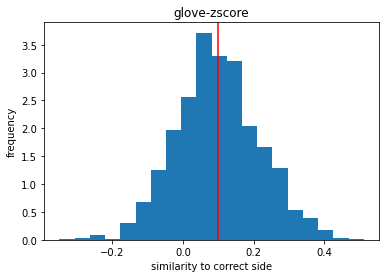

In [178]:
scores0 = plot_axes_quality('glove-zscore')

BEST [('cardinal.a.02_right', 0.46587843275706514), ('democratic.a.01_right', 0.45688202820996093), ('established.a.01_right', 0.4457313786380787), ('proved.a.01_right', 0.4400854343410742), ('diligent.a.02_left', 0.4298208091532249), ('used.a.01_left', 0.42174856144216466), ('prospective.a.01_left', 0.4127038229058156), ('partial.a.02_right', 0.3980450580154516), ('nourished.a.01_right', 0.3915070398937059), ('all.a.01_left', 0.3797426857709725)]
WORST [('leeward.a.01_left', -0.2969628124826152), ('left-handed.a.01_left', -0.27629508544904546), ('east.a.01_right', -0.2724861278640515), ('alkaline.a.01_left', -0.2609350143981471), ('western.a.02_left', -0.2469994684001294), ('right-handed.a.01_right', -0.22041623298552349), ('same.a.01_left', -0.21482705170077418), ('left-handed.a.01_right', -0.1928498721136952), ('right.a.01_right', -0.1880249658281328), ('like.a.01_left', -0.18562359995196703)]
AVG SIMILARITY TO CORRECT SIDE: 0.10148170209867674


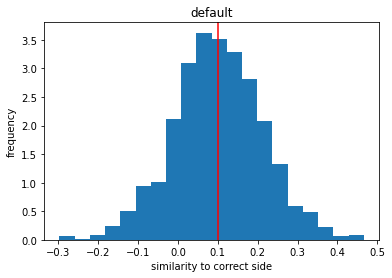

In [179]:
# GloVe 
scores1 = plot_axes_quality('default')

good: 388
bad: 335


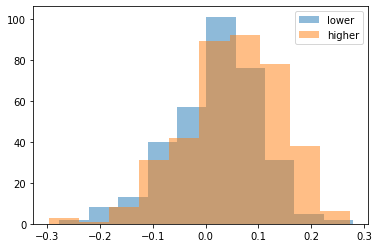

In [258]:
plot_axes_consistency('default', scores1)

In [212]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_default.json', scores1)

**** BIAS **** Writing
0.31935673509090984 0.02398796896122792
0.189 employed.a.01 (employed, engaged, hired, working)
0.15916500174958584 0.2483074381828082
0.178 original.a.03 (avant-garde, daring, freehand, fresh, germinal, groundbreaking, innovative, new, newfangled, novel, original, seminal)
0.20964709755898384 0.13533390890054042
0.177 skilled.a.01 (accomplished, adept, arch, complete, consummate, delicate, expert, good, hot, masterful, masterly, mean, practiced, proficient, skilful, skilled, skillful, technical, versatile, virtuoso)
0.3480915250822464 0.27873869978949045
0.176 known.a.01 (best-known, better-known, celebrated, famed, famous, identified, illustrious, known, legendary, notable, noted, proverbial, renowned, well-known)
0.11345123320881839 0.2320243068774707
-0.175 dominant.a.01 (adjunct, assistant, associate, low-level, secondary, subordinate, under)

**** BIAS **** Theater, film, TV, entertainment
0.3480915250822464 0.27873869978949045
0.173 known.a.01 (best-known,

BEST [('cosmopolitan.a.02_left', 0.4688037444572688), ('established.a.01_right', 0.4596850064984086), ('diligent.a.02_left', 0.44453673857165804), ('perfect.a.01_right', 0.4236236618175155), ('democratic.a.01_right', 0.42250865007703964), ('coastal.a.02_left', 0.4197461159100794), ('rural.a.01_right', 0.404912632665243), ('loyal.a.01_right', 0.40454635135829137), ('proved.a.01_right', 0.4010928313641157), ('accordant.a.01_right', 0.3786686542925012)]
WORST [('right.a.07_right', -0.24983714360112655), ('middle-class.a.01_right', -0.21872887699865978), ('lower-class.a.01_right', -0.2060201658683339), ('left-handed.a.01_left', -0.2055182739316395), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('simple.a.06_right', -0.18363307685494304), ('plausible.a.01_left', -0.18247291968936494), ('upper-class.a.01_left', -0.18238383433328156), ('right-handed.a.01_right', -0.16924812978017423)]
AVG SIMILARITY TO CORRECT SIDE: 0.08362568852321235


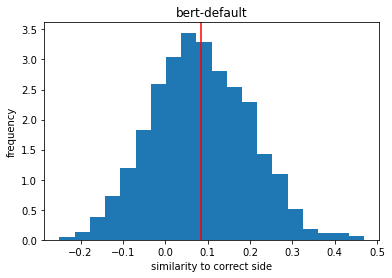

In [181]:
scores2 = plot_axes_quality('bert-default')

good: 357
bad: 366


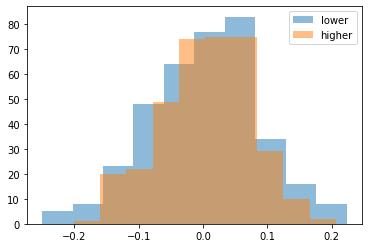

In [259]:
plot_axes_consistency('bert-default', scores2)

In [182]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-default.json', scores2)

**** BIAS **** Writing
0.13713425546818744 0.0895843198168669
0.16 creative.a.01 (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.23414870267852508 0.12390943774321042
0.147 colorful.a.02 (brave, colorful, colourful, flashy, gaudy, gay, jazzy, many-sided, noisy, picturesque, showy, sporty)
0.14213076695697618 0.014237428760686765
0.147 intellectual.a.02 (good, highbrow, intellectual, rational, reflective, serious, sophisticated)
0.1416398022869489 0.040799572322002396
0.138 high.a.04 (adenoidal, altissimo, alto, countertenor, falsetto, high, high-pitched, nasal, peaky, pinched, screechy, sharp, shrill, sopranino, soprano, spiky, squeaking, squeaky, squealing, tenor, treble)
0.3169379393209748 0.027516185216536086
0.132 controlled.a.01 (contained, controlled, disciplined, dominated, harnessed, obsessed, possessed, regimented)

**** BIAS **** Theater, film, TV, entertainment
0.23414870267852508 0.12390943774321042
0.155 colorful.a.02 (brave, colorful, colourful, 

In [211]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-default.json', scores2, show_bias_sep=True)

---- BIAS SEPARATION ---- Writing
sep	bias other	bias this
0.018 	 0.141 	 0.16 	 active.a.03 (active, activist, hands-on, proactive)
0.018 	 0.121 	 0.104 	 orthodox.a.02 (dissident, heretical, heterodox, iconoclastic, nonconforming, nonconformist, recusant, unorthodox)
0.017 	 0.078 	 0.095 	 creative.a.01 (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.017 	 -0.168 	 -0.185 	 military.a.03 (civil, civilian, noncombatant)
0.017 	 0.013 	 -0.004 	 authorized.a.01 (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)

---- BIAS SEPARATION ---- Theater, film, TV, entertainment
sep	bias other	bias this
0.025 	 0.069 	 0.044 	 practical.a.01 (crazy, half-baked, impractical, quixotic, romantic, screwball, unwieldy, wild-eyed)
0.024 	 0.127 	 0.103 	 conventional.a.01 (alternative, bizarre, bohemian, devil-may-care, eccentric, flakey, flaky, freakish, freaky, funky, gonzo, irregular, kinky, maverick, off-the-wall, offbeat, outlandish, o

BEST [('established.a.01_right', 0.7128654591087947), ('proved.a.01_right', 0.597348440505184), ('coastal.a.02_left', 0.5270812601005884), ('diligent.a.02_left', 0.5165721453509411), ('metallic.a.01_right', 0.49213767707043665), ('democratic.a.01_right', 0.4862461882147111), ('plowed.a.01_left', 0.4752572112226283), ('intended.a.01_right', 0.4651066646676007), ('rural.a.01_right', 0.46163459646137867), ('forgiving.a.01_right', 0.4601450252009643)]
WORST [('right.a.07_right', -0.3213553830676028), ('simple.a.06_right', -0.2620479319468943), ('bidirectional.a.01_right', -0.25582223249191377), ('digestible.a.01_left', -0.24308950260323658), ('lower-class.a.01_right', -0.2430803260853753), ('right.a.01_right', -0.21990475026335854), ('carnivorous.a.02_left', -0.2184862543944103), ('right-handed.a.01_right', -0.2178111344365374), ('left-handed.a.01_left', -0.19309641478934833), ('plausible.a.01_left', -0.18839614085761364)]
AVG SIMILARITY TO CORRECT SIDE: 0.10769832351044133


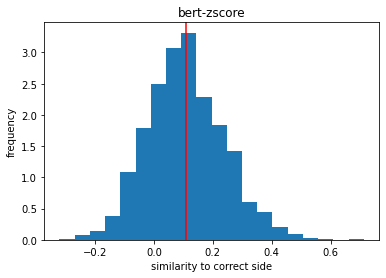

In [184]:
scores3 = plot_axes_quality('bert-zscore')

good: 358
bad: 365


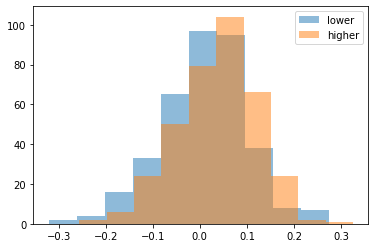

In [260]:
plot_axes_consistency('bert-zscore', scores3)

In [185]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-zscore.json', scores3)

**** BIAS **** Writing
0.14852060587464333 0.1576693167175466
0.158 creative.a.01 (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.2500087633400165 0.1714486112632145
0.147 humane.a.02 (child-centered, human-centered, humane, humanist, humanistic, humanitarian)
0.1023535224342039 0.035186378408389715
0.125 communicative.a.02 (anecdotal, chatty, communicable, communicational, communicative, expansive, expressive, gesticulating, gestural, gossipy, heraldic, leaky, narrative, newsy, nonverbal, openhearted, outspoken, sign, signed, talkative, tattling, verbal, vocal)
0.09271286137013175 0.22898187826608574
0.115 constructive.a.01 (constructive, creative, formative, inferential, plastic, reconstructive, rehabilitative, shaping, structural)
0.1288736436357568 0.14524087078676018
-0.115 separate.a.01 (clannish, collective, concerted, conjoined, conjoint, conjunct, conjunctive, cooperative, corporate, joint)

**** BIAS **** Theater, film, TV, entertainment
0.2316232596

In [210]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-zscore.json', scores3, show_bias_sep=True)

---- BIAS SEPARATION ---- Writing
sep	bias other	bias this
0.027 	 -0.142 	 -0.169 	 formal.a.01 (casual, daily, everyday, folksy, informal, unceremonious)
0.026 	 -0.045 	 -0.071 	 used.a.01 (abused, exploited, misused, put-upon, used, victimised, victimized)
0.026 	 0.093 	 0.119 	 active.a.03 (active, activist, hands-on, proactive)
0.025 	 0.031 	 0.056 	 corrupt.a.01 (corrupt, corrupted, corruptible, debased, depraved, dirty, dishonest, perverse, perverted, purchasable, putrid, reprobate, sold-out, sordid, venal, vitiated)
0.024 	 -0.016 	 -0.04 	 authorized.a.01 (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)

---- BIAS SEPARATION ---- Theater, film, TV, entertainment
sep	bias other	bias this
0.032 	 0.064 	 0.032 	 practical.a.01 (crazy, half-baked, impractical, quixotic, romantic, screwball, unwieldy, wild-eyed)
0.031 	 0.071 	 0.04 	 corrigible.a.01 (incorrigible, uncontrollable, unmanageable, unregenerate)
0.031 	 0.016 	 -0.015 	 prepared.a.

BEST [('rural.a.01_right', 0.537118127650585), ('supported.a.01_left', 0.5040856697113334), ('neutral.a.04_left', 0.4758780803178785), ('diligent.a.02_left', 0.4595827598890135), ('free.a.02_right', 0.44856743207687344), ('altered.a.01_left', 0.4378228556549071), ('established.a.01_right', 0.43126933612950064), ('democratic.a.01_right', 0.4264018423610463), ('coastal.a.02_left', 0.42425361124382244), ('perfect.a.01_right', 0.42023356337569745)]
WORST [('leeward.a.01_left', -0.4201295583072303), ('middle-class.a.01_right', -0.22754660094477402), ('fast.a.03_left', -0.22590593164132136), ('left-handed.a.01_right', -0.21669846619543492), ('binaural.a.01_left', -0.20629685310374105), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('perpendicular.a.01_right', -0.1961126398017065), ('conclusive.a.01_right', -0.19302776984830788), ('aggressive.a.01_right', -0.180344412303889)]
AVG SIMILARITY TO CORRECT SIDE: 0.10111439061407065


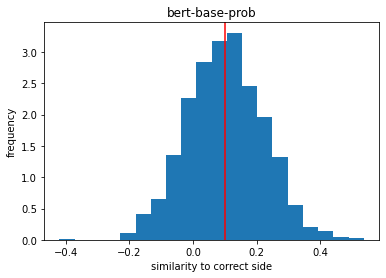

In [187]:
scores7 = plot_axes_quality('bert-base-prob')

good: 346
bad: 377


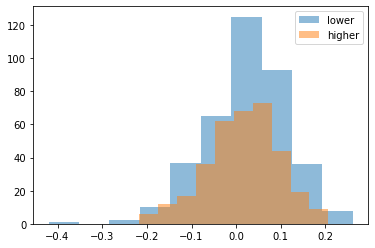

In [261]:
plot_axes_consistency('bert-base-prob', scores7)

In [215]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob.json', scores7)

**** BIAS **** Writing
0.136758512824579 0.2118964946017049
0.19 creative.a.01 (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.15279478129439392 0.0026764314203486907
0.162 high.a.04 (adenoidal, altissimo, alto, countertenor, falsetto, high, high-pitched, nasal, peaky, pinched, screechy, sharp, shrill, sopranino, soprano, spiky, squeaking, squeaky, squealing, tenor, treble)
0.04916011036898577 0.13809685096105187
-0.157 fatty.a.01 (fat-free, light, lite, nonfat, skim, skimmed)
0.28974487663157983 3.001219889853246e-05
0.157 trustworthy.a.01 (authentic, creditworthy, dependable, fiducial, honest, reliable, responsible, sure, true, trusted, trustworthy, trusty)
0.09458364633486596 0.31539383389594605
0.155 intended.a.01 (calculated, conscious, deliberate, intended, intentional, knowing, measured, well-intentioned, well-meaning, witting)

**** BIAS **** Theater, film, TV, entertainment
0.14166239305930653 0.13691182314276204
0.155 rhetorical.a.02 (bombastic, decl

In [214]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob.json', scores7, show_bias_sep=True)

---- BIAS SEPARATION ---- Writing
sep	bias other	bias this
0.025 	 -0.056 	 -0.081 	 more (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
0.022 	 0.017 	 -0.005 	 more (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)
0.022 	 0.135 	 0.157 	 more (active, activist, hands-on, proactive)
0.021 	 0.047 	 0.025 	 less (braced, embattled, equipped, preconditioned, precooked, prepared, processed, ready, spread, up)
0.021 	 -0.016 	 -0.038 	 more (branded, copyrighted, patented, proprietary, trademarked)

---- BIAS SEPARATION ---- Theater, film, TV, entertainment
sep	bias other	bias this
0.031 	 0.05 	 0.018 	 less (applicative, functional, interoperable, matter-of-fact, operable, practicable, practical, pragmatic, serviceable, unimaginative, working)
0.025 	 0.112 	 0.087 	 less (conventional, customary, formulaic, received, stodgy, stuffy)
0.023 	 0.107 	 0.084 	 less (amendable, correctable, redeemable)
0.022 	 0.134 	 0.112 	 l

BEST [('supported.a.01_left', 0.6833822959092323), ('established.a.01_right', 0.6829843944926698), ('rural.a.01_right', 0.639917481470154), ('free.a.02_right', 0.6175253363276528), ('neutral.a.04_left', 0.5686822206895885), ('competent.a.01_right', 0.5196700189642048), ('diligent.a.02_left', 0.5164681395491898), ('enclosed.a.01_right', 0.5083512129991592), ('coastal.a.02_left', 0.50820548876679), ('proved.a.01_right', 0.5047085530521541)]
WORST [('leeward.a.01_left', -0.45403881636601556), ('fast.a.03_left', -0.2934507718164514), ('analytic.a.03_left', -0.27760758358063103), ('bidirectional.a.01_right', -0.25582223249191377), ('right-handed.a.01_right', -0.25441354848997005), ('binaural.a.01_left', -0.24329229826648505), ('right.a.01_right', -0.23654425383397926), ('lower-class.a.01_right', -0.23409926013122906), ('carnivorous.a.02_left', -0.2184862543944103), ('left-handed.a.01_right', -0.20770977760706244)]
AVG SIMILARITY TO CORRECT SIDE: 0.12920738938029552


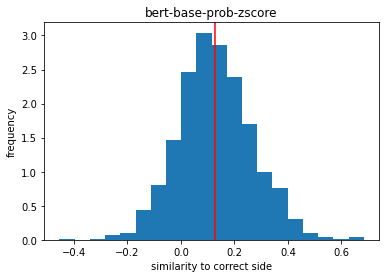

In [190]:
scores8 = plot_axes_quality('bert-base-prob-zscore')

In [218]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob-zscore.json', scores8)

**** BIAS **** Writing
0.22888089119288713 0.04442493151253748
-0.175 intensifying.a.01 (analgesic, anodyne, moderating, palliative, tempering, weakening)
0.10254884910650391 0.36634065511634933
0.154 creative.a.01 (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.09382550730931534 0.007025247607185259
0.13 logical.a.01 (discursive, formal, logical)
0.13548275052554998 0.20246770081753637
-0.13 spoken.a.01 (backhand, cursive, engrossed, graphic, graphical, handwritten, holographic, inscribed, longhand, shorthand, written)
0.21011172578555934 0.2700045717702676
0.128 humane.a.02 (child-centered, human-centered, humane, humanist, humanistic, humanitarian)

**** BIAS **** Theater, film, TV, entertainment
0.22888089119288713 0.04442493151253748
-0.169 intensifying.a.01 (analgesic, anodyne, moderating, palliative, tempering, weakening)
0.20393992146493123 0.0935706537675874
-0.119 separate.a.01 (clannish, collective, concerted, conjoined, conjoint, conjunct, conjunct

In [208]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob-zscore.json', scores8, show_bias_sep=True)

---- BIAS SEPARATION ---- Writing
sep	bias other	bias this
0.039 	 -0.129 	 -0.168 	 formal.a.01 (casual, daily, everyday, folksy, informal, unceremonious)
0.033 	 -0.013 	 -0.046 	 noble.a.02 (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
0.031 	 0.081 	 0.112 	 active.a.03 (active, activist, hands-on, proactive)
0.031 	 0.014 	 -0.017 	 authorized.a.01 (self-appointed, unaccredited, unauthorised, unauthorized, unlicenced, unlicensed)
0.029 	 0.023 	 -0.006 	 prepared.a.01 (ad-lib, extemporaneous, extempore, impromptu, off-the-cuff, offhand, offhanded, unprepared, unrehearsed)

---- BIAS SEPARATION ---- Theater, film, TV, entertainment
sep	bias other	bias this
0.04 	 0.054 	 0.014 	 practical.a.01 (crazy, half-baked, impractical, quixotic, romantic, screwball, unwieldy, wild-eyed)
0.031 	 0.071 	 0.04 	 corrigible.a.01 (incorrigible, uncontrollable, unmanageable, unregenerate)
0.03 	 0.028 	 -0.002 	 prepared.a.01 (ad-lib, extemporaneous, extempore, impro

good: 351
bad: 372


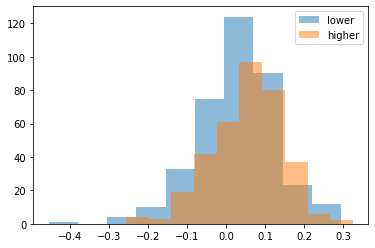

In [262]:
plot_axes_consistency('bert-base-prob-zscore', scores8)

In [57]:
# U-tests
# z-scored bert prob vs. glove
print(mannwhitneyu(list(scores8.values()), list(scores1.values())))
# z-scored bert prob vs. z-scored bert random
print(mannwhitneyu(list(scores8.values()), list(scores3.values())))
# z-scored bert random vs. glove
print(mannwhitneyu(list(scores3.values()), list(scores1.values())))

MannwhitneyuResult(statistic=928174.0, pvalue=8.765265395555834e-08)
MannwhitneyuResult(statistic=761820.0, pvalue=3.8193132107419166e-05)
MannwhitneyuResult(statistic=651919.0, pvalue=1.241232364039564e-22)


In [58]:
def get_num_words_per_side(): 
    # returns dictionary of synset_side : # of adj
    num_words = {}
    with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
        for line in infile: 
            contents = line.split('\t')
            synset = contents[0]
            axis1 = contents[1].split(',')
            num_words[synset + '_left'] = len(axis1)
            axis2 = contents[2].split(',')
            num_words[synset + '_right'] = len(axis2)
    return num_words
    
def get_num_vectors_per_side(exp_name): 
    # returns dictionary of synset_side : # of vectors
    vec_dict = get_bert_vecs(exp_name)
    if 'sub' not in exp_name: 
        num_vectors = Counter()
        for pole in axes: 
            for side_pole in [pole + '_left', pole + '_right']: 
                if 'left' in side_pole: 
                    side = axes[pole][0]
                else: 
                    side = axes[pole][1]
                for w in side: 
                    ss_adj = w + '@' + side_pole
                    if ss_adj in vec_dict:  
                        num_vectors[side_pole] += 1 
        return num_vectors
    in_folder = LOGS + 'wikipedia/substitutes/' + exp_name + '/'
    with open(in_folder + 'word_rep_key.json', 'r') as infile: 
        word_rep_keys = json.load(infile)
    num_vectors = Counter()
    for pole in axes: 
        for side_pole in [pole + '_left', pole + '_right']: 
            if 'left' in side_pole: 
                side = axes[pole][0]
            else: 
                side = axes[pole][1]
            if side_pole not in word_rep_keys:
                # fall back on bert random
                for w in side: 
                    ss_adj = w + '@' + side_pole
                    if ss_adj in vec_dict:  
                        num_vectors[side_pole] += 1 
            else: 
                rep_keys = word_rep_keys[side_pole] # [[line_num, word]]
                these_words = []
                for i, rk in enumerate(rep_keys): 
                    line_num = rk[0]
                    w = rk[1]
                    these_words.append(w)
                side_vec = np.load(in_folder + side_pole + '.npy')
                num_vectors[side_pole] = len(side_vec)
    return num_vectors
    
def get_num_polysemous_per_side(): 
    # returns dictionary of synset_side : # of polysemous words
    num_axis_per_word = Counter()
    with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
        for line in infile: 
            contents = line.split('\t')
            synset = contents[0]
            axis1 = contents[1].split(',')
            for w in axis1: 
                num_axis_per_word[w] += 1
            axis2 = contents[2].split(',')
            for w in axis2: 
                num_axis_per_word[w] += 1
    cutoff = 5
    polysemous_words = set()
    for w in num_axis_per_word: 
        if num_axis_per_word[w] > 10: 
            polysemous_words.add(w)
    num_words = {}
    with open(LOGS + 'semantics_val/wordnet_axes.txt', 'r') as infile: 
        for line in infile: 
            contents = line.split('\t')
            synset = contents[0]
            axis1 = contents[1].split(',')
            if set(axis1) & polysemous_words: 
                num_words[synset + '_left'] = 1
            else: 
                num_words[synset + '_left'] = 0
            axis2 = contents[2].split(',')
            if set(axis2) & polysemous_words: 
                num_words[synset + '_right'] = 1
            else: 
                num_words[synset + '_right'] = 0
    return num_words

In [309]:
num_words = get_num_words_per_side()
num_polysemous = get_num_polysemous_per_side()

In [391]:
def compare_axis_quality(scores_dict1, scores_dict2, third_dim, title):
    x = []
    y = []
    z = []
    for k in scores_dict1: 
        if k in scores_dict2: 
            x.append(scores_dict1[k])
            y.append(scores_dict2[k])
            z.append(third_dim[k])
    plt.scatter(x, y, c=z, cmap='coolwarm')
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.title(title)
    plt.show()
    
def plot_polysemous(scores_dict):
    polys = []
    non_polys = []
    for k in num_polysemous: 
        if num_polysemous[k] == 0: 
            non_polys.append(scores_dict[k])
        else: 
            polys.append(scores_dict[k])
    plt.hist(non_polys)
    plt.axvline(x=np.mean(non_polys), color='blue')
    plt.hist(polys)
    plt.axvline(x=np.mean(polys), color='orange')
    plt.title("BERT default scores, polysemous vs. non-polysemous")
    plt.show()
    
def plot_num_vectors(scores_dict, num_vectors):
    many = []
    few = []
    for k in num_vectors: 
        if 'left' in k: 
            other_k = k.replace('_left', '_right')
        else: 
            other_k = k.replace('_right', '_left')
        total = num_vectors[k] + num_vectors[other_k]
        if total > 100: 
            many.append(scores_dict[k])
        else: 
            few.append(scores_dict[k])
    plt.hist(many, alpha=0.5)
    plt.axvline(x=np.mean(many), color='blue')
    plt.hist(few, alpha=0.5)
    plt.axvline(x=np.mean(few), color='orange')
    plt.title("many vectors vs. few vectors")
    plt.show()

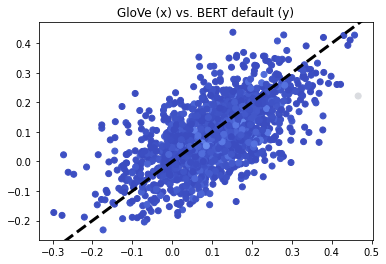

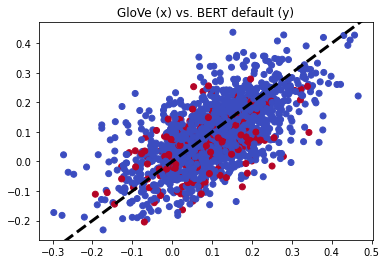

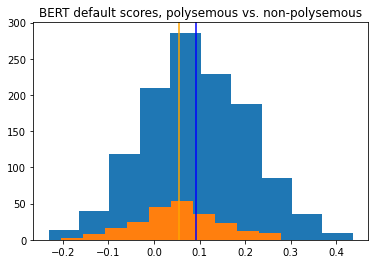

In [392]:
compare_axis_quality(scores1, scores2, num_words, 'GloVe (x) vs. BERT default (y)')
compare_axis_quality(scores1, scores2, num_polysemous, 'GloVe (x) vs. BERT default (y)')
plot_polysemous(scores2)

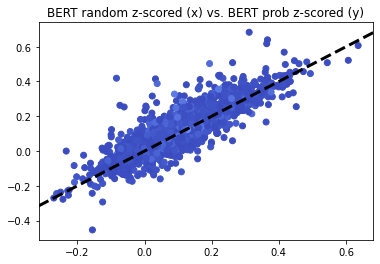

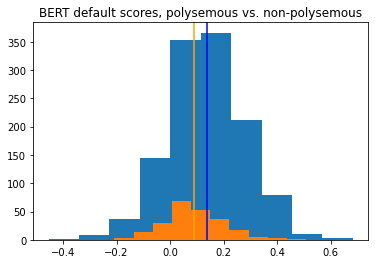

In [406]:
compare_axis_quality(scores3, scores8, num_words, 'BERT random z-scored (x) vs. BERT prob z-scored (y)')
plot_polysemous(scores8)

In [59]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None,
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])

    return texts

def get_side_pole_rep(side, in_folder, vec_dict, both_vec, words, side_pole, word_rep_keys): 
    if side_pole not in word_rep_keys:
        print("Falling back on bert random for", side)
        # fall back on bert random
        for w in side: 
            ss_adj = w + '@' + side_pole
            if ss_adj in vec_dict:  
                both_vec.append(vec_dict[ss_adj])
                words.append(w)   
    else: 
        rep_keys = word_rep_keys[side_pole] # [[line_num, word]]
        these_words = []
        for i, rk in enumerate(rep_keys): 
            line_num = rk[0]
            w = rk[1]
            these_words.append(w)
        side_vec = np.load(in_folder + side_pole + '.npy')
        if 'zscore' in exp_name: 
            bert_mean = np.load(LOGS + 'wikipedia/mean_BERT.npy')
            bert_std = np.load(LOGS + 'wikipedia/std_BERT.npy')
            side_vec = (side_vec - bert_mean) / bert_std
        single_vec_per_word = defaultdict(list)
        for i, row in enumerate(side_vec): 
            w = these_words[i]
            single_vec_per_word[w].append(side_vec[i])
        # aggregate reps for each word
        for w in sorted(single_vec_per_word.keys()): 
            words.append(w)
            both_vec.append(np.mean(single_vec_per_word[w], axis=0))
    return both_vec, words

def generate_heatmap(pole, vec_dict, axes, exp_name): 
    if 'sub' in exp_name: 
        if 'mask' not in exp_name: 
            in_folder = LOGS + 'wikipedia/substitutes/bert-base-sub/'
        elif 'mask' in exp_name: 
            in_folder = LOGS + 'wikipedia/substitutes/bert-base-sub-mask/'
        else: 
            in_folder = LOGS + 'wikipedia/substitutes/' + exp_name + '/'
        with open(in_folder + 'word_rep_key.json', 'r') as infile: 
            word_rep_keys = json.load(infile)
        both_vec = []
        words = []
        print("Getting side pole rep...")
        left = axes[pole][0]
        right = axes[pole][1]
        both_vec, words = get_side_pole_rep(left, in_folder, vec_dict, both_vec, words, 
                                            pole + '_left', word_rep_keys)
        both_vec, words = get_side_pole_rep(right, in_folder, vec_dict, both_vec, words, 
                                            pole + '_right', word_rep_keys)
    else: 
        left = axes[pole][0]
        both_vec = []
        words = []
        for w in left: 
            k = w+'@'+pole+'_left'
            if k in vec_dict: 
                words.append(w)
                both_vec.append(vec_dict[k])

        right = axes[pole][1]
        for w in right: 
            k = w+'@'+pole+'_right'
            if k in vec_dict: 
                words.append(w)
                both_vec.append(vec_dict[k])
        both_vec = np.array(both_vec)
    
    sim = cosine_similarity(both_vec)
    fig, ax = plt.subplots()

    im, cbar = heatmap(sim, words, words, ax=ax, 
                       cmap="YlGn", cbarlabel="similarity")
    texts = annotate_heatmap(im)

    fig.tight_layout()
    plt.show()

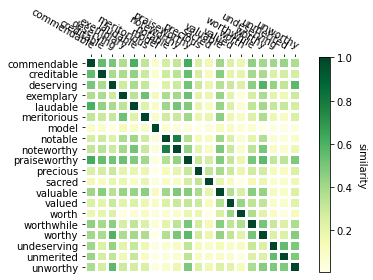

In [60]:
exp_name = 'bert-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('worthy.a.01', bert_vecs, axes, exp_name)

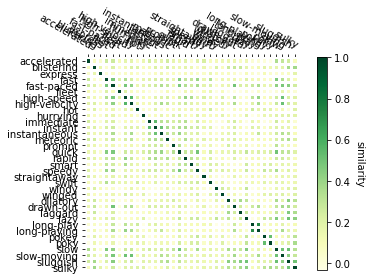

In [61]:
exp_name = 'bert-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('fast.a.01', bert_vecs, axes, exp_name)

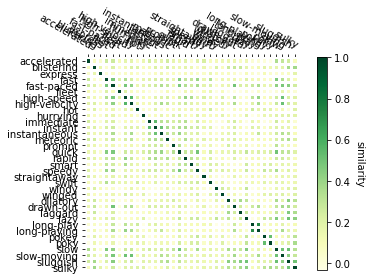

In [62]:
exp_name = 'bert-prob-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('fast.a.01', bert_vecs, axes, exp_name)

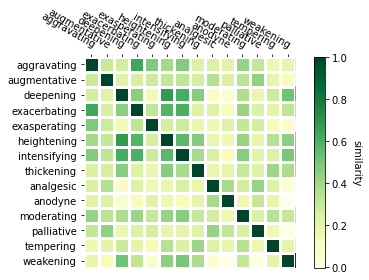

In [63]:
exp_name = 'bert-prob-zscore'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('intensifying.a.01', bert_vecs, axes, exp_name)

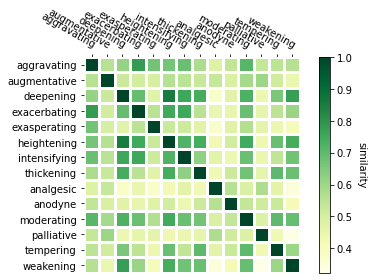

In [64]:
exp_name = 'bert-prob'
bert_vecs = get_bert_vecs(exp_name)
generate_heatmap('intensifying.a.01', bert_vecs, axes, exp_name)